In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import pandas as pd
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [2]:
path = os.path.dirname(os.getcwd()) +  "\\GIS\\Files\\land_use_sub_basin_mechelbach_split_*.gpkg"

In [3]:
files = glob.glob(path)

In [4]:
lst_layers = []
for i, file in enumerate(files):
    gdf = gpd.read_file(file)
    gdf = gdf[["Landuse",'area_ha']]
    gdf["area_ha"] = gdf["area_ha"] / gdf["area_ha"].sum() * 100
    section_name = file.split("_")[-1].split(".")[0]
    gdf.rename(columns={"area_ha":section_name, "Landuse":"percentage_per_landuse"},inplace=True)
    lst_layers.append(gdf.set_index("percentage_per_landuse").T)

In [5]:
df = pd.concat(lst_layers).fillna(0)
df.index = df.index.astype(int)
df.sort_index(inplace=True)
df.to_excel("combined_landuse_percentages_per_catchment.xlsx")

In [6]:
lst_layers_ha = []
for i, file in enumerate(files):
    gdf = gpd.read_file(file)
    gdf = gdf[["Landuse",'area_ha']]
    # gdf["area_ha"] = gdf["area_ha"] / gdf["area_ha"].sum() * 100
    section_name = file.split("_")[-1].split(".")[0]
    gdf.rename(columns={"area_ha":section_name, "Landuse":"ha_per_landuse"},inplace=True)
    lst_layers_ha.append(gdf.set_index("ha_per_landuse").T)

In [7]:
df_ha = pd.concat(lst_layers_ha).fillna(0)
print(f'Total area is {df_ha.sum(axis=1).sum():.3f} ha')

Total area is 1070.082 ha


In [8]:
df_ha['total_area'] = df_ha.sum(axis=1)
df_ha.index = df_ha.index.astype(int)
df_ha.sort_index(inplace=True)

In [9]:
subbasin_file = os.path.dirname(os.getcwd()) + "\\GIS\\Files\\sub_basins_mechelbach_dissolved2.gpkg"

In [10]:
gdf = gpd.read_file(subbasin_file)
df_area = gdf[['section_number','area_ha']].set_index('section_number')
df_area.sort_index(inplace=True)
print(f'Total area is {df_area.sum(axis=1).sum():.3f} ha')

Total area is 1070.847 ha


In [11]:
df_area.to_excel("area_per_catchment.xlsx")

In [12]:
df_Q = pd.read_excel("results_Q.xlsx")
df_Q.set_index("Section",inplace=True)

In [13]:
df_TWI = pd.read_csv("TWI per catchment2.csv")[['section_number','TWI__average','TWI__sum']]
df_TWI = df_TWI.set_index("section_number")
df_TWI.index = df_TWI.index.astype(int)
df_TWI.sort_index(inplace=True)

In [14]:
df_TWI

,TWI__average,TWI__sum
section_number,,
1,9.796246,868701.729205
2,9.033403,3008.123239
3,9.937165,551771.029745
4,9.427233,307214.666424
5,9.673257,172135.602616
6,8.467215,2709.508724
7,8.855292,3365.010994
8,8.781323,168566.284671
9,9.781069,166190.142896


In [15]:
df_combined = pd.concat([df_Q, df_area,df,df_TWI],axis=1)

In [16]:
# l/s / ha =? *10^-3 = m^3/s/ha -> 10-7 m^3/s/m^2= 10-7m/s = 10-4mm/s = 10-4 * 86400 mm/d
df_combined['Q_specific'] = df_combined['Q'] / df_combined['area_ha'] * 10**(-4) * 86400

In [17]:
df_combined.sort_values("area_ha",ascending=False)

,Q,area_ha,Forest,Settlement,Agriculture,Transport,Natural surfaces,Water,TWI__average,TWI__sum,Q_specific
1,190.00,221.691019,16.286943,4.709982,73.883741,2.802838,2.316497,0.000000,9.796246,868701.729205,7.404901
3,93.10,138.814514,74.066660,2.222837,21.463650,2.010968,0.235885,0.000000,9.937165,551771.029745,5.794668
26,14.56,106.096899,14.125312,1.702600,81.607673,1.910632,0.653782,0.000000,9.771860,414707.963010,1.185693
4,3.69,81.469700,60.894703,0.000000,34.496244,2.575278,2.033775,0.000000,9.427233,307214.666424,0.391331
19,10.51,80.412148,36.154917,5.894247,53.081109,3.545238,1.324490,0.000000,9.028921,290415.254631,1.129262
12,5.66,75.749650,20.789841,13.979297,60.671524,3.579617,0.979721,0.000000,9.731462,294863.287630,0.645579
15,13.73,54.342278,50.890452,29.656425,14.790140,3.098598,1.398387,0.165999,9.680804,210431.633077,2.182963
24,3.35,48.402266,8.333333,10.416667,77.083333,4.166667,0.000000,0.000000,9.910750,191882.035541,0.597989
8,73.22,47.989809,82.370119,0.000000,14.726520,2.903361,0.000000,0.000000,8.781323,168566.284671,13.182399
5,88.48,44.487336,91.431068,0.000000,4.062249,2.433733,2.072950,0.000000,9.673257,172135.602616,17.183929


In [18]:
df_combined_filtered = df_combined[(df_combined.area_ha > 8.0000) & (df_combined.Q_specific > 0.00000)]

In [19]:
color_dict ={ 
            "Forest": "#105c1d",
            "Agriculture": "#f1f12d",
            "Settlement":"#a92213",
            "TWI__average":"C0",
            "TWI__sum":"C0"
                }

In [20]:
# def calc_rmse(obs, mod):
#     return np.sum((np.array(obs)-np.array(mod))**2)
def f(x, slope, intercept):
    # y = mx + c
    return slope * x + intercept

In [52]:
df_combined_filtered

,Q,area_ha,Forest,Settlement,Agriculture,Transport,Natural surfaces,Water,TWI__average,TWI__sum,Q_specific
1,190.00,221.691019,16.286943,4.709982,73.883741,2.802838,2.316497,0.000000,9.796246,868701.729205,7.404901
3,93.10,138.814514,74.066660,2.222837,21.463650,2.010968,0.235885,0.000000,9.937165,551771.029745,5.794668
4,3.69,81.469700,60.894703,0.000000,34.496244,2.575278,2.033775,0.000000,9.427233,307214.666424,0.391331
5,88.48,44.487336,91.431068,0.000000,4.062249,2.433733,2.072950,0.000000,9.673257,172135.602616,17.183929
8,73.22,47.989809,82.370119,0.000000,14.726520,2.903361,0.000000,0.000000,8.781323,168566.284671,13.182399
9,2.37,42.477328,46.423833,0.000000,51.759272,1.816895,0.000000,0.000000,9.781069,166190.142896,0.482064
12,5.66,75.749650,20.789841,13.979297,60.671524,3.579617,0.979721,0.000000,9.731462,294863.287630,0.645579
14,41.80,43.509804,45.051042,0.485662,52.091126,2.372170,0.000000,0.000000,9.963468,173404.203415,8.300474
15,13.73,54.342278,50.890452,29.656425,14.790140,3.098598,1.398387,0.165999,9.680804,210431.633077,2.182963
17,41.21,13.184937,46.153846,0.000000,53.846154,0.000000,0.000000,0.000000,9.800516,51687.921154,27.004633


In [77]:
def plot(Q, col, save=True, title=True, color_dict=color_dict):
    # plottig 
    df_plot = df_combined_filtered[[Q,col]].copy()
    if col == "Settlement": 
        df_plot_zeros = df_plot[df_plot[col]==0]  # 'store' the zero values
        df_plot = df_plot[df_plot[col]!=0] # remove areas with no settlements from the regression 
    df_plot.dropna(inplace=True)
    ax = df_plot.plot(kind='scatter', x=col, y=Q, color=color_dict[col])
    if col == "Settlement": df_plot_zeros.plot(kind='scatter', x=col, y=Q, color=color_dict[col], ax=ax, alpha=0.5, label="0% settlement catchments\nexcluded in regression")
    if col == "Agriculture": df_plot.plot(kind='scatter', x=col, y=Q, color='k',s=22, ax=ax, zorder=-1) # make yellow more visible
    # trend
    x = np.linspace(min(df_plot[col]),max(df_plot[col]),1000)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_plot[col], df_plot[Q])
    plt.plot(x, f(x, slope, intercept), color="k")
    plt.annotate(f'r={r_value:.3f}',(x[len(x)//2]+(max(x)-min(x))/8,f(x[len(x)//2], slope, intercept)))
    # specifying per tupe
    if Q == "Q_specific": Q_label = "Specific Discharge (mm/d)"
    elif Q == "Q": Q_label = "Discharge l/s"
    else: Q_label = Q
    if col[:3] == "TWI": col_label = f'{col[5:]} {col[:3]}'
    else: col_label = f'precentage {col} cover'
    
    plt.xlabel(col_label)
    plt.ylabel(Q_label)
    # plt.title(f"Relation between {col_label} and \nobserved {Q_label[:-len('(mm/d)')]} per catchment")
    if save:
        plt.savefig(f'Figures\\results_{col}_vs_{Q}.png',dpi=600 )
        

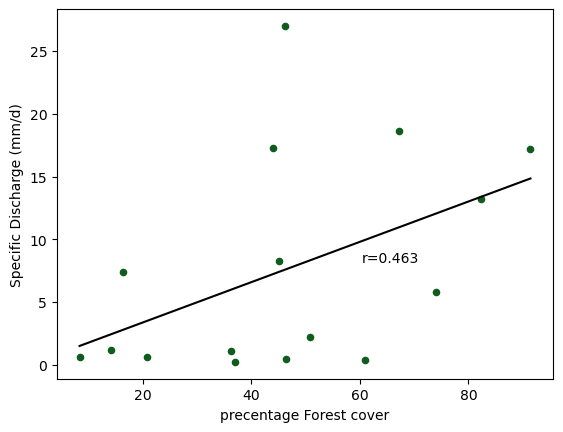

In [78]:
col = 'Forest'
Q = "Q_specific"
plot(Q, col, save=True, title=True)

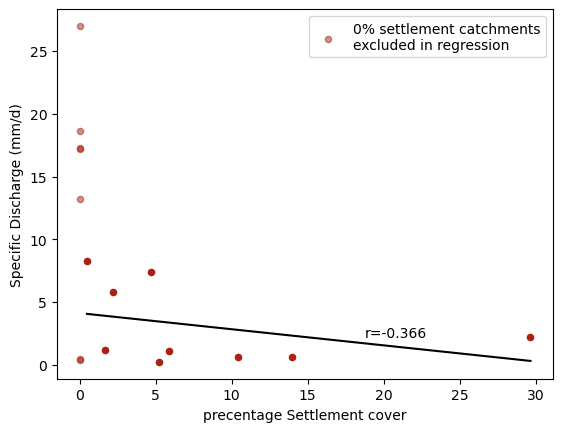

In [79]:
col = 'Settlement'
Q = "Q_specific"
plot(Q, col, save=True, title=True)

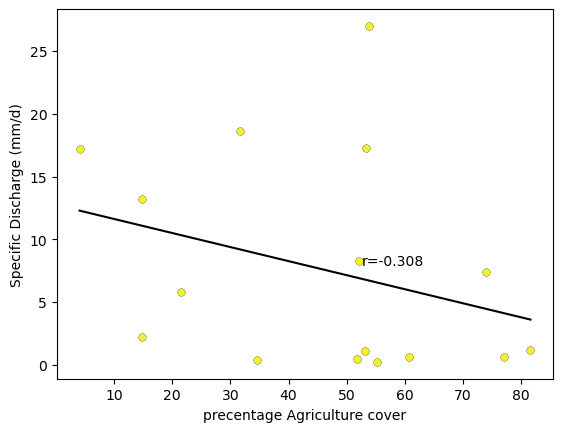

In [80]:
col = 'Agriculture'
Q = "Q_specific"
plot(Q, col, save=True, title=True)

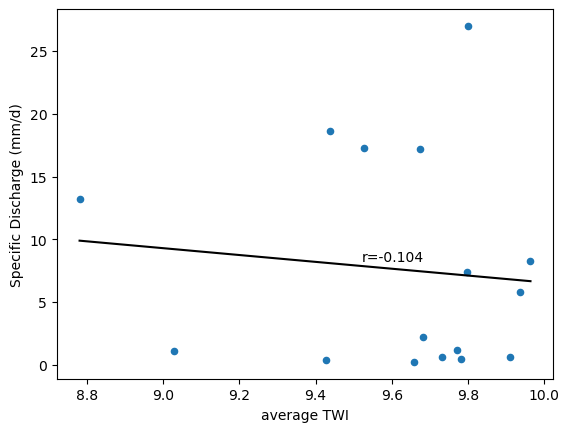

In [81]:
col = 'TWI__average'
Q = 'Q_specific'
plot(Q, col, save=True, title=True)

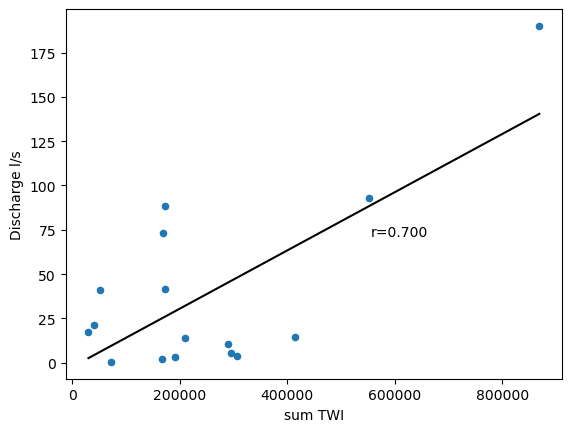

In [82]:
col = 'TWI__sum'
Q = 'Q'
plot(Q, col, save=True, title=True)